---
layout: default
title: "Deep Learning - RNN - Sequence to sequence models"
categories: deeplearning
permalink: /ML46/
order: 46
comments: true
---

In [1]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["mathtext.fontset"] = "cm"
from mpl_flow import Flow

Populating the interactive namespace from numpy and matplotlib


# Sequence to sequence models
Sequence to sequence models are RNN algorithms that take sequences as input and produce sequences as output. They are employed in many fields from machine translation to speech recognition.

Machine translation is the perfect example of the reason why sequence to sequence models have been developed. Almost all the examples seen so far map an input sequence to a single output. In machine translation we want to translate a sentence from a language to a second sequence in another. 

## Basic seq-to-seq model
Suppose we have a sentence in French that we want to map to its English translation:

$$
\begin{split}
&\begin{array}
&x^{\langle 1 \rangle} & x^{\langle 2 \rangle} & x^{\langle 3 \rangle} & x^{\langle 4 \rangle} & x^{\langle 5 \rangle} \\
\text{Jane} & \text{visite} & \text{l'Afrique} & \text{en} & \text{septembre}
\end{array}\\ \\
&\begin{array}
&\text{Jane} & \text{is} & \text{visiting} & \text{Africa} & \text{in} & \text{September} \\
y^{\langle 1 \rangle} & y^{\langle 2 \rangle} & y^{\langle 3 \rangle} & y^{\langle 4 \rangle} & y^{\langle 5 \rangle} & y^{\langle 6 \rangle} 
\end{array}
\end{split}
$$

In order to map such input sequences to output sequences, [Sutskever et.al. 2014](https://arxiv.org/abs/1409.3215) and [Cho et.al.2014](https://arxiv.org/abs/1406.1078) developed RNN based seq-to-seq models. These models are made of an **encoder** network and a **decoder** network. The encoder processes the input sequence and then feeds it to the decoder, which produces the output sequence (<a href="#fig:seq2seqbasic">figure below</a>).

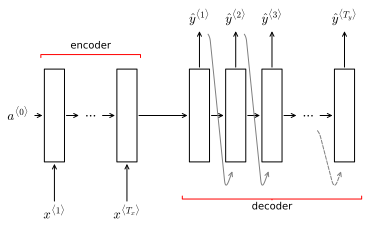

In [2]:
f = Flow(bbox=dict(boxstyle='square'))
for i in range(1, 9):
    d=1
    lbl = i if i < 5 else 'T_x'

    if i not in [2,7]:
        if i == 4:
            d=2
        f.node(f'a{i}', label='\n'*5+' '*3, fontsize=13, startpoint=f'a{i-1}', distance=d)
    else:
        f.node(f'a{i}', label='$\\cdots$', startpoint=f'a{i-1}', fontsize=13, bbox=dict(ec='none'))

    if i < 4 and i != 2:
        if i == 3:
            lbl = 'T_x'
        f.node(f'x{i}', label=f'$x^{{\\langle {lbl} \\rangle}}$', startpoint=f'a{i}',
               travel='s', fontsize=13, 
               edge_kwargs=dict(arrowprops=dict(arrowstyle='->')), bbox=dict(ec='none')) 

    if i >= 4 and i != 7:
        if i == 8:
            lbl = 'T_y'
        else:
            lbl = i - 3

        f.node(f'y{i}', label=f'$\\hat{{y}}^{{\\langle {lbl} \\rangle}}$', startpoint=f'a{i}', travel='n', fontsize=13,
               bbox=dict(ec='none'))
    
    if i > 4 and i < 7:
        f.edge(f'y{i-1}', f'a{i}', headport='s', tailport='s', 
           arrowprops=dict(connectionstyle='arc,angleA=-110,angleB=-10,armA=30,armB=10,rad=10', 
                           shrinkA=10, shrinkB=10, ec='gray'))
    if i == 8:
        f.edge(f'a{i-1}', f'a{i}', headport='s', tailport='s', 
           arrowprops=dict(connectionstyle='arc,angleA=-110,angleB=-10,armA=30,armB=10,rad=10', 
                           shrinkA=10, shrinkB=10, ec='gray', ls='--'))

f.node(startpoint='a1', label='$a^{\\langle 0 \\rangle}$', travel='w', fontsize=13, bbox=dict(ec='none'),
       edge_kwargs=dict(arrowprops=dict(arrowstyle='->')))

encoder_bbox = f.nodes['a2'].annotation.get_bbox_patch()
decoder_bbox = f.nodes['a6'].annotation.get_bbox_patch()
plt.annotate('encoder', (0.5, 3.5), (0.5, 3.8) , xycoords=encoder_bbox, textcoords=encoder_bbox, ha='center', 
             arrowprops=dict(arrowstyle='-[,widthB=5,lengthB=0.3,angleB=0', ec='r'))
plt.annotate('decoder', (0.5, -0.4), (0.5, -0.43) , xycoords=decoder_bbox, textcoords=decoder_bbox, ha='center', va='top',
             arrowprops=dict(arrowstyle='-[,widthB=9,lengthB=0.3,angleB=0', ec='r'));

<i id="fig:seq2seqbasic">A basic sequence to sequence RNN architecture with an encoder and a decoder. The encoder process the input sequence and feeds it to the decoder, which produces th output sequence</i>

The encoder and decoder are two separate networks that serve separate purposes. The task of the encoder is to produce a standard encoding (or we could say an embedding) of an input, while the task of the decoder is to interpret map the encoding to a sequence. 

To further sustain this point, the decoder can also be a convolutional network processing an image. In **image captioning** tasks in fact the ALEX-net, once the final sofmtax layer is removed, plays the role of the decoder network producing a 4096-dimensional encoding of an image, which is then fed to a decoder that produces a caption for the image. 

## Selecting the most likely translation
The decoder network in <a href="#fig:seq2seqbasic">the figure above</a> is a language model (<a href="page:ML44">ML-44</a>) in that it outputs the probability of the translated sentence 

$$P \left(y^{\langle 1 \rangle}, \dots, y^{\langle T_y \rangle} \right)$$

However, differently from a language model, its input is not a 0-padded vector $a^{\langle 0 \rangle}$ but it is instead the encoding produced by the encoder network. Thus, this language model outputs the conditional probability of the translation, given a certain input sentence $x$

$$
\begin{equation}
P \left (y^{\langle 1 \rangle}, \dots, y^{\langle T_y \rangle} \vert x \right )
\end{equation} \label{eq:transl} \tag{1}
$$

Each, input sentence might have different output sentences, each with its own probability associated. For example for the input french sentence:

```
Jane visite l'Afrique en septmebre
```

We could have the following sentences:

```
Jane is visiting Africa in September

Jane is going to be visiting Africa in September

In September, Jane will visit Africa

Her African friend welcomed Jane in September
```

So $\eqref{eq:transl}$ denotes a distribution of probabilities associated to different sentences. When feeding the input sentence to the machine translation algorithm we don't want to sample randomly from the output distribution since, while all sentences are strictly speaking correct, we can easily say that some are better translations than others in most contexts. Instead we want to select the **most likely translation**.

$$
\begin{equation}
\underset{y^{\langle 1 \rangle}, \dots, y^{\langle T_y \rangle}}{\arg \max} P \left (y^{\langle 1 \rangle}, \dots, y^{\langle T_y \rangle} \vert x \right )
\end{equation} \label{eq:mostliktransl} \tag{2}
$$

### Greedy Search
One possible, suboptimal, to select the most likely translation is to perform a **greedy search**. In a greedy search we would proceed to iteratively select the most likely element in the sequence (next word in the sentence) until completion.

However, we can see how this approach is suboptimal by looking at the following example. Given the two translations

```
Jane is visiting Africa in September

Jane is going to be visiting Africa in September
```

Where the first is better (more likely) than the second, a greedy search would probably select the second since the words `Jane is going` are very common english words and are more likely than `Jane is visiting`.

### Approximate Search
Instead of maximizing the probability $\eqref{eq:transl}$ by selecting one word at the time, we would like to select the group of words that, together, maximizes that probability.

However to explore the translation sentence space exahustively would the computationally impossible. In fact, given a vocabulary of 10000 words and only considering sentences of 10 words we would have $10^{10000}$ possible sentences to test.

For this reason **approximate search** algorithms are used that find near-optimal solutions quickly. One of the most common approximate search algorithsm is called **Beam search**

## Beam Search
Beam search is an heuristic algorithm that scans the distribution in $\eqref{eq:transl}$ and tries to select the most likely sentence. Differently from exact search algorithms like [BFS](https://en.wikipedia.org/wiki/Breadth-first_search) and [DFS](https://en.wikipedia.org/wiki/Depth-first_search), Beam search is not guaranteed to find the best $P(y \vert x)$ .In Beam search we start by finding the best first word, but instead of selecting one word (as in a greedy search), we select multiple most likely words for position $\langle 1 \rangle$. 

$$
P \left ( y^{\langle 1 \rangle} \vert x \right)
$$

The number of first words to pick is determined by an hyperparameter called **beam width** ($B$). At each step of Beam search, a number of possible options equal to the beam width are selected. A beam width of 3 means that the 3 most likely first words are used to build a sentence.

Once the array of first words is selected, for each of them the whole vocabulary is scanned to find the most likely following words, given the input $x$ and the first word $y^{\langle 1 \rangle}$

$$
\begin{equation}
P \left ( y^{\langle 1 \rangle},y^{\langle 2 \rangle} \vert x \right) = P \left ( y^{\langle 1 \rangle} \vert x \right)P \left ( y^{\langle 2 \rangle} \vert x,  y^{\langle 1 \rangle} \right)
\end{equation} \label{eq:beam2} \tag{3}
$$

Supposing $B=3$ and vocabulary size $n=10000$, we would have to compute $\eqref{eq:beam2}$ 30000 times. During this second step, exactly $B$ most likely sentences are kept and brought forward. Any sentence whose first word is one of the second words in the $B$ selected sentences, is discarded.

Beam search then proceeds by computing the third word in the translation $y^{\langle 3 \rangle}$ given its first two words and the input.

$$
P \left ( y^{\langle 1 \rangle},y^{\langle 2 \rangle}, y^{\langle 3 \rangle} \vert x \right) =  P \left ( y^{\langle 1 \rangle} \vert x \right)P \left ( y^{\langle 2 \rangle} \vert x,  y^{\langle 1 \rangle} \right) P \left (  y^{\langle 3 \rangle} \vert x , y^{\langle 1 \rangle}, y^{\langle 2 \rangle} \right )
$$

$B$ options are selected and the process is repeated until the sequence is complete. In the case of a machine translation algorithm, this usually happens when a $\small \langle \text{EOF} \rangle$ token is reached.
At the end of the process the probability to maximize is

$$
P \left ( y^{\langle 1 \rangle}, \dots, y^{\langle T_y \rangle} \vert x \right) =  P \left ( y^{\langle 1 \rangle} \vert x \right)P \left ( y^{\langle 2 \rangle} \vert x,  y^{\langle 1 \rangle} \right) \dots P \left (  y^{\langle T_y \rangle} \vert x , y^{\langle 1 \rangle}, \dots, y^{\langle T_y-1 \rangle} \right )
$$


which can be written as

$$
\begin{equation}
\arg \max_y \prod_{t=1}^{T_y} P \left( y^{\langle t \rangle} \vert x, y^{\langle 1 \rangle}, \dots, y^{\langle t-1 \rangle} \right)
\end{equation} \label{eq:beamsearch} \tag{4}
$$

### Log sum
Given a large enough $T_y$ or small enough $P \left( y \vert x \right)$, $\eqref{eq:beamsearch}$ can produce extremely small numbers that can cause numerical underflow.

So instead of using $\eqref{eq:beamsearch}$ it is common to use its $\log$. Since the log of a product is equivalent to the sum of the logs of its factors we have

$$
\begin{equation}
\arg \max_y \sum_{t=1}^{T_y} \log P \left( y^{\langle t \rangle} \vert x, y^{\langle 1 \rangle}, \dots, y^{\langle t-1 \rangle} \right)
\end{equation} \label{eq:logbeamsearch} \tag{5}
$$

$\eqref{eq:logbeamsearch}$ is numerically stable and less prone to numerical underflow problems. Since the log function is monotonically increasing (<a href="#fig:log">figure below</a>), we know that maximizing $\eqref{eq:beamsearch}$ should give the same results as maximizing $\eqref{eq:logbeamsearch}$

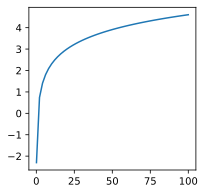

In [3]:
fig, ax = plt.subplots(figsize=(3, 3))
x = np.linspace(0.1, 100, 51)
y = np.log(x)
plt.plot(x, y);

<i id="fig:log">Logarithmic function</i>

### Length normalization
Another side effect of the objective function $\eqref{eq:beamsearch}$ (and $\eqref{eq:logbeamsearch}$) is that it becomes smaller the longer the sequence. This means that it will tend to unnaturally prefer short over long sequences. To prevent this problem the objective function is usually normalized by length by dividing by the number of elements in the output sequence.

$$
\begin{equation}
\frac{1}{T_y^\alpha} \sum_{t=1}^{T_y} \log P \left( y^{\langle t \rangle} \vert x, y^{\langle 1 \rangle}, \dots, y^{\langle t-1 \rangle} \right)
\end{equation} \label{eq:lengthbeamsearch} \tag{6}
$$

Where if the hyperparameter $\alpha=0$, we are maximizing the sum of the logs of probabilities exactly as in $\eqref{eq:logbeamsearch}$ (no normalization), whereas if $\alpha=1$, we are maximizing the average of logs of probabilities (full normalization). Commonly, a value of $\alpha$ in the range $[0, 1]$ is applied to have non-full normalization and a value that has been empirically found to work well for most applications is $\alpha = 0.7$.

### Choice of Beam Width
The larger $B$ is, the more possible sequences we are exploring and thus the better probability of finding the best output sequence. On the other hand, the larger $B$ is, the more computationally expensive the algorithm.

In production systems is not uncommon the find values of $B$ around 10, whereas $B$ around 100 would be considered very large. However, the choice of $B$ is very domain-dependent and, when necessary $B$ can need to be as large as 1000 or 3000.

It is important to notice that in most cases large values of $B$ gives diminishing returns, so it is expected to see huge gains in performance increasing $B$ at low values ($1 \to 10$) while very small gains in performance when increasing $B$ at large values ($1000 \to 3000$)

### Error analysis with Beam Search
Since Beam Search is an heuristic algorithm it doesn't necessarily find an optimal solution. Error analysis of Beam Search can help understand whether it is the Beam Search or the underlying RNN model that needs improving.

Suppose you have the input sentence

```
Jane visite l'Afrique en septembre
```

And the following human translation $y^*$ in your development set

```
Jane visits Africa in September
```

And the output from Beam searching your RNN model $\hat{y}$ is instead

```
Jane visited Africa last September
```

We can't known in *a priori* if the beam width is too small or the RNN model is not performing adequately. Since the RNN is computing $P(y \vert x)$, to understand how well is the model performing we can compare the probability of $y^*$ and $\hat{y}$

$$
P \left(y^* \vert x \right) - P \left(\hat{y} \vert x \right) 
\begin{cases}
> 0 \quad \to \quad \scriptsize\text{improve Beam Search} \\
\leq 0 \quad \to \quad \scriptsize\text{improve RNN}
\end{cases}
$$

* If $P(y^* \vert x) > P(\hat{y} \vert x)$ it means that Beam Search chose $\hat{y}$ but $y^*$ would attain higher $P(y \vert x)$. So Beam Search is failing to find the optimal solution.
* If $P(y^* \vert x) \leq P(\hat{y} \vert x)$ it means that Beam Search chose $\hat{y}$ *because it attains* a higher $P(y \vert x)$. So Beam Search is working fine but the RNN model is not trained well.

To carry out a comprehensive error analysis we can check the responsibility of all errors in our development set. If Beam Search is at fault for a large fraction of them, increasing the value of $B$ should resolve the issue. If errors are due to a faulty RNN model, then we ca carry out a deeper layer of error analysis as detailed in <a href="page:ML15">ML-15</a>.

## BLEU Score
Unlike in tasks like image recognition, where there's one right answer, in machine translation there might be multiple equally good answers and it becomes impossible to measure accuracy traditionally. Conventionally accuracy in machine translation is measured with the **BiLingual Evaluation Undesrstudy (BLEU) score** ([Papineni et.al. 2002](https://www.aclweb.org/anthology/P02-1040.pdf)).

Suppose we have an input French sentence

```
Le chat est sur le tapis
```

and two equally correct human translations

```
The cat is on the mat

There is a cat on the mat
```

The BLEU score works by checking if the type of words in the machine translation appear in at least one of the human generated references. It calculates a modified **precision** score on all **n-grams**, where a unigram is a single word, a bigrmam is a pair of consecutive words and so on.

To understand how the modified precision is calculated, suppose the machine translation output is

```
the the the the the the the
```

To calculate the modified precision of the unigrams, we compute the ratio of the clipped number of occurrences of a unigram ($\scriptsize\text{Count}_{\text{clip}}$) in the machine translation output ($\hat{y}$) to its unclipped occurrences ($\scriptsize\text{Count}$). Clipped occurrences are calculated by counting how many of the unigram in the output appear in any of the references. The count is clipped to the maximum number of times the unigram appears in any one of the references. In this case all $7$ unigrams of the translation appear in the reference but, since the word `the` is found at most 2 times in the references (first reference), the count is clipped to 2 and the precision for unigrams $p_1 = \frac{2}{7}$. In the general case in which there are more than one word in the machine translation, we can write $p_1$ as

$$
p_1 = \frac{\sum_{\small\text{unigram } \in \hat{y}}\small\text{Count}_\text{clip} (\text{unigram})}
{\sum_{\small\text{unigram } \in \hat{y}}\small\text{Count}(\text{unigram})}
$$

And this can be extended to the n-gram case

$$
p_n = \frac{\sum_{\small\text{n-gram } \in \hat{y}}\small\text{Count}_\text{clip} (\text{n-gram})}
{\sum_{\small\text{n-gram } \in \hat{y}}\small\text{Count}(\text{n-gram})}
$$

$p_n = 1$ when the sentence is exactly the same of a reference or a combination of references that hopefully still constitutes a good translation.

The combined BLEU score usually assumes values of $p_n \in [1,4]$ and it is defined as

$$
\text{BP} \exp \left ( \frac{1}{4} \sum_{n=1}^4 p_n \right )
$$

where $\text{BP}$ stands for **brevity penalty** which penalizes translations shorter than the references, which would tend to have bigger scores. $\text{BP}$ is defined as

$$
\text{BP} = 
\begin{cases}
1 &\quad \small \text{len}(\hat{y}) > \text{len}(y^*) \\
\exp \left (1 - \frac{\text{len}(y^*)}{\text{len}(\hat{y})} \right) &\quad \small\text{otherwise} 
\end{cases}
$$

## Attention model 
The attention model is an alternative to the encoder decoder architecture. 

### Attention model motivation
The intuition behind attention models is best introduced by looking at machine translation task for a long sentence. Suppose we have the input sentence

```
Jane s'est rendue en Afrique en septembre dernier, a apprécié la culture et a rencontré beaucoup de gens merveilluex; elle est revenue en parlant comment son voyage était merveilluex, et elle me tente d'y aller aussi.
```

And its reference translation

```
Jane went to Africa last Septembre, and enjoyed the culture and met many wonderful people; she came back raving about how wonderful the trip was, and is tempting me to go too.
```

An encoder-decoder model would take the whole sentence as input, encode it in a $n$-dimensional vector and then pass it to the decoder network to produce a translation. However, this is not how a human translator would proceed. A human translator is likely to translate the sentence one piece a time and proceed until completion. 

And so what we observe for encoder-decoder models is that they work well for short sentences but sentences longer than some tens of words, their performance decay. Attention models don't suffer from this performance decay (<a href="fig:attentionBLEU">figure below</a>).

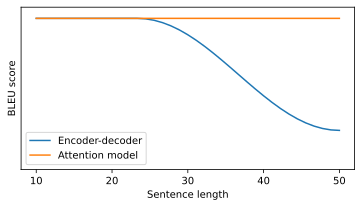

In [4]:
fig, ax = plt.subplots(figsize=(6, 3))
x = np.linspace(.5*np.pi, 1.5*np.pi, 25)
x2 = np.linspace(0, .5*np.pi, 25)
y = np.sin(x)
y2 = np.ones(x2.shape)

ax.plot(np.r_[x2, x], np.r_[y2, y], label='Encoder-decoder')
ax.plot(np.r_[x2, x], np.r_[y2, y2], label='Attention model')
ax.set_xticks(np.linspace(0, 1.5*np.pi, 5))
ax.set_xticklabels(np.arange(10, 60, 10))
ax.set_yticks([])
ax.set_ylabel('BLEU score')
ax.set_xlabel('Sentence length')
ax.set_ylim(-1.7, 1.2)
ax.legend();

<i id ="fig:attentionBLEU">Performance comparison of encoder-decoder and attention models for increasing length of sentences. The performance, calculated as BLEU score, of the encoder-decoder model decays for sentences longer than 25-30 words. Performance of the attention model tends to stay consistently high for longer sentences.</i>

### Attention model
Suppose we have an input sentence

```
Jane visite l'Afrique en septembre
```

And we use a bidirectional RNN (more commonly bidirectional GRU and bidirectional LSTM) to compute features on every word (<a href="#fig:attentionmodel">figure below</a>, bottom network). The notation for this bidirectional network is as follows: each step in the input sequence is $t^\prime$,  we denote with $\overrightarrow{a}^{\langle t^\prime \rangle}$ the forward occurrence and with  $\overleftarrow{a}^{\langle t^\prime \rangle}$ the backward occurrence of the network. For brevity we denote 

$$a^{\langle t^\prime \rangle} = \left(\overrightarrow{a}^{\langle t^\prime \rangle}, \overleftarrow{a}^{\langle t^\prime \rangle} \right)$$

Then we have a forward only RNN with state $s^{\langle t \rangle}$ that produces the output sequence $\hat{y}^{\langle t \rangle}$ (<a href="#fig:attentionmodel">figure below</a>, top network). Each step is fed a context $c^{\langle t \rangle}$ and the output from the previous step $\hat{y}^{\langle t-1 \rangle}$. The context of each step is fed the output from all the input activations $a^{\langle t^\prime \rangle}$ weighted by the **attention weights** $\alpha^{\langle t, t^\prime \rangle}$. The **attention weights** modulate how much the context of a step in the output sequence depends on the features ($a^{\langle t^\prime \rangle}$) of each time step in the input sequence. The context is in fact a weighted sum of the features of each time step in the input weighted by its attention weight.

$$
c^{\langle t \rangle} = \sum_{t^\prime}\alpha^{\langle t, t^\prime \rangle}a^{\langle t^\prime \rangle}
$$

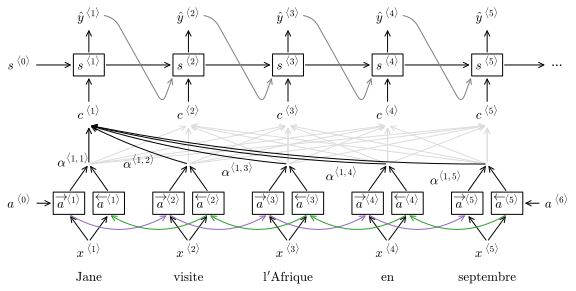

In [76]:
f = Flow(bbox=dict(boxstyle='square'), figsize=(10, 5), fontsize=13)
sentence = "Jane visite l'Afrique en septembre".split()
label = lambda b, i: '${}^{{ \\; \\langle {} \\rangle}}$'.format(b, i)
f.node('a0f', label=label('a', 0), bbox=dict(ec='none'))
for i, w in enumerate(sentence):
    f.node(f'a{i+1}f', startpoint=f'a{i}f', label=label('\\overrightarrow{{a}}', i+1), 
           connect=False if i > 0 else True, distance=1 if i > 0 else .5)
    f.node(f'a{i+1}b', distance=.4, startpoint=f'a{i+1}f', label=label('\\overleftarrow{{a}}', i+1), connect=False)
    f.node(f'a{i+1}', distance=(.2, 1), startpoint=f'a{i+1}f', label=label('x', i+1), travel='se', bbox=dict(ec='none'),
          edge_kwargs=dict(headport='n', tailport='s', arrowprops=dict(arrowstyle='->')))
    f.edge(f'a{i+1}', f'a{i+1}b', headport='s', tailport='n')
    f.node(f'w{i+1}', distance=.5, startpoint=f'a{i+1}', label=f'$\\mathrm{{{w}}}$', connect=False, travel='s',
          bbox=dict(ec='none'))
    f.node(f'o{i+1}', distance=(.2, 1), startpoint=f'a{i+1}f', label=' ', travel='ne', bbox=dict(ec='none'),
          edge_kwargs=dict(headport='s', tailport='n' ))
    f.edge(f'a{i+1}b', f'o{i+1}', headport='s', tailport='n')
    
    f.node(f'c{i+1}', label=label('c', i+1), travel='n', distance=.8, bbox=dict(ec='none'), 
                 edge_kwargs=dict(tailport='s', labelpos=(-2.5, 0.3), arrowprops=dict(ec='gainsboro')))
    f.node(f's{i+1}', label=label('s', i+1), travel='n', startpoint=f'c{i+1}')
    f.node(f'y{i+1}', label=label('\\hat{{y}}', i+1), travel='n', startpoint=f's{i+1}', bbox=dict(ec='none'))

    
    if i > 0:
        f.edge(f'a{i}f', f'a{i+1}f', tailport='s', headport='s', 
               arrowprops=dict(connectionstyle='arc3,rad=-.3', ec='C4'))
        f.edge(f'a{i+1}b', f'a{i}b', tailport='s', headport='s', 
               arrowprops=dict(connectionstyle='arc3,rad=.3', ec='C2'))
        f.edge(f's{i}', f's{i+1}')
        f.edge(f'y{i}', f's{i+1}', headport='sw', tailport='e', 
       arrowprops=dict(connectionstyle='arc,angleA=-110,angleB=-10,armA=30,armB=10,rad=10', 
                       shrinkA=2, shrinkB=0, ec='gray'))
            

f.node(f'a{len(sentence)+1}f', label=label('a', len(sentence)+1), bbox=dict(ec='none'), startpoint=f'a{len(sentence)}b',
       edge_kwargs=dict(arrowprops=dict(arrowstyle='->')), distance=.5)
f.node('s0', label=label('s', 0), bbox=dict(ec='none'), startpoint=f's1',
       edge_kwargs=dict(arrowprops=dict(arrowstyle='->')), distance=.7, travel='w')
f.node(f's{len(sentence)+1}', label='$\\cdots$', bbox=dict(ec='none'), startpoint=f's{len(sentence)}', distance=.7)


for i in range(len(sentence)):
    for j, xpos, ypos in zip(range(len(sentence)), 
                             [-2.5, 0.5, 0.75, 0.85, 0.9], 
                             [0, 0, -.2, -.3, -.4]
                            ):
        if i == 0:
            f.edge(f'o{j+1}', 'c1', tailport='s', headport='s', zorder=10,
                   label=f'$\\alpha^{{\\langle 1,{j+1} \\rangle}}$', 
                   arrowprops=dict(connectionstyle=f'arc3,rad={0.05 if j > 0 else 0}'), labelpos=(xpos, ypos))
        else:
            f.edge(f'o{j+1}', f'c{i+1}', tailport='s', headport='s', arrowprops=dict(ec='gainsboro'))


<i id="fig:attentionmodel">An attention model for a machine translation task. The input sequence is processed by a bi-directional network, which feeds into an forward network passing through a context layer. Each context layer is fed the activation (features) of all time-steps of the bi-directional network, weighted by a set of attention weights, which define how much each activation contributes to the output</i>

The attention weights satisfy the condition

$$
\begin{equation}
\sum_{t^\prime} \alpha^{\langle t, t^\prime \rangle} = 1
\end{equation} \label{eq:attwond} \tag{4}
$$

This means that the attention weights that modulate the contribution to the output step $t$ of each input steps $t^\prime$, sum to 1. The attention weights definition is built to satisfy $\eqref{eq:attwond}$:

$$
a ^{\langle t, t^\prime \rangle} = \frac{\exp \left( e^{\langle t, t^\prime \rangle} \right)}
{\sum_{t^\prime=1}^{T_x}\exp \left( e^{\langle t, t^\prime \rangle} \right)}
$$

The terms $e^{ \langle t, t^\prime \rangle}$ are usually computed by using a small neural network (usually with 1 hidden layer) that takes as input the state from the previous time step ($s^{\langle t-1 \rangle}$) and the features from the current time step $a^{\langle t^\prime \rangle}$. The intuition behind this process is that if you want to know how much the current step $s^{\langle t \rangle}$ should pay to the activation $a^{\langle t^\prime \rangle}$, it should depend on the previous state  $s^{\langle t-1 \rangle}$ and on the activation itself.

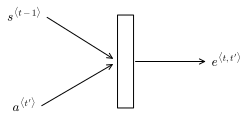

In [98]:
f = Flow(fontsize=13, figsize=(4, 2), bbox=dict(ec='none', boxstyle='square'))
f.node(label=r'$s^{\langle t-1 \rangle}$')
f.node(label=r'$a^{\langle t^\prime \rangle}$', travel='s', connect=False)
f.node(label='  \n\n\n\n\n', travel='ne', distance=(1, .5), bbox=dict(ec='k'), 
       edge_kwargs=dict(tailport='e', headport='w', arrowprops=dict(shrinkA=5)))
f.node(label=r'$e^{\langle t, t^\prime \rangle}$')
f.edge(1, 3, arrowprops=dict(shrinkA=5), tailport='e', headport='w');

<i id="attentionweightnetwork">The network that determines the weighting function for state $s^{\langle t \rangle}$</i>